# When Will You Die In PLAYERUNKNOWN'S BATTLEGROUNDS?

## What is PLAYERUNKNOWN'S BATTLEGROUNDS?

PLAYERUNKNOWN'S BATTLEGROUNDS, aka PUBG, is a Battle Royale online game with an enormous player community. A battle royale game has typically 100 players in an arena with weapons and items scattered throughout the arena, where players drop into the map and try to gether loot in order to outlive everybody else.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
d = pd.read_csv('data/agg_match_stats_1k.csv')
e = pd.read_csv('data/agg_match_stats_2k.csv')
a = pd.read_csv('data/agg_match_stats_3k.csv')
t = pd.read_csv('data/agg_match_stats_4k.csv')
h = pd.read_csv('data/agg_match_stats_5k.csv')
x = pd.concat([d,e,a,t,h])
#d=d[d.party_size==1]
f = x[['game_size','match_mode','party_size','player_name','player_survive_time','team_placement','match_id']]
f['match_id'].astype(str)
f = f[f.party_size == 1]
f = f[f.player_survive_time <= 2000]
y = f[f.team_placement >= 75]
print(x.info())
print(f)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99995 entries, 0 to 19998
Data columns (total 15 columns):
date                   99995 non-null object
game_size              99995 non-null int64
match_id               99995 non-null object
match_mode             99995 non-null object
party_size             99995 non-null int64
player_assists         99995 non-null int64
player_dbno            99995 non-null int64
player_dist_ride       99995 non-null float64
player_dist_walk       99995 non-null float64
player_dmg             99995 non-null int64
player_kills           99995 non-null int64
player_name            99841 non-null object
player_survive_time    99995 non-null float64
team_id                99995 non-null int64
team_placement         99995 non-null int64
dtypes: float64(3), int64(8), object(4)
memory usage: 12.2+ MB
None
       game_size match_mode  party_size       player_name  \
494           91        tpp           1             Satch   
495           91        tpp    

## What is the average amount of time that a player in a match will survive?

In [3]:
g = f.groupby('team_placement').player_survive_time.mean()
print(g)
i = f.groupby('match_id').player_survive_time.mean()
i = i[i <= 900]
print(i.head())
j = y.groupby('match_id').player_survive_time.mean()
#print(j.head())
k = f.groupby('team_placement').count()

team_placement
1     1875.167810
2     1876.691854
3     1824.539949
4     1766.245115
5     1729.136050
6     1681.644735
7     1647.661454
8     1614.920253
9     1584.503170
10    1552.207138
11    1524.516837
12    1494.531694
13    1468.598203
14    1446.108305
15    1415.670177
16    1389.271452
17    1367.995194
18    1331.880315
19    1298.605152
20    1267.635316
21    1242.297832
22    1208.943169
23    1182.368663
24    1148.920024
25    1120.581816
26    1097.680322
27    1067.097827
28    1029.518365
29    1018.568602
30     990.544315
         ...     
70     230.277366
71     217.353010
72     219.577121
73     213.843685
74     195.350098
75     196.412884
76     200.631826
77     184.706525
78     180.454152
79     178.203135
80     165.376043
81     178.114837
82     167.785897
83     157.130969
84     162.735794
85     150.426516
86     151.373033
87     132.247475
88     137.792358
89     167.831301
90     156.633818
91     134.168974
92     164.374988
93     137.13

### Average survival time for each team placement

In [4]:
print(f.groupby('team_placement').count())

                game_size  match_mode  party_size  player_name  \
team_placement                                                   
1                     205         205         205          205   
2                     205         205         205          205   
3                     216         216         216          216   
4                     217         217         217          217   
5                     222         222         222          221   
6                     223         223         223          223   
7                     218         218         218          218   
8                     221         221         221          221   
9                     218         218         218          217   
10                    218         218         218          218   
11                    215         215         215          215   
12                    219         219         219          218   
13                    217         217         217          216   
14        

Histogram shows the probability of survival time in a game

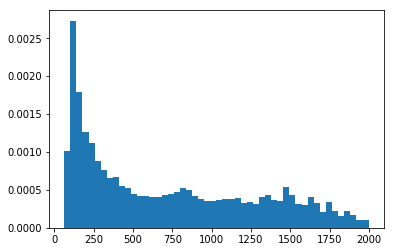

In [5]:
plt.hist(f.player_survive_time,bins=50,normed=True)
plt.show()

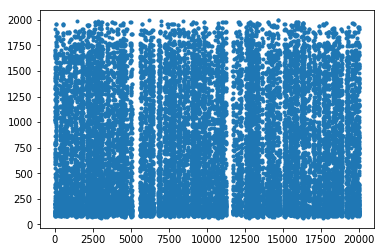

In [6]:
plt.plot(f.player_survive_time,marker='.',linestyle='None')
plt.show()

The scatterplot of player survive times gives no useful information since there are too many data points without and indication of a trend.

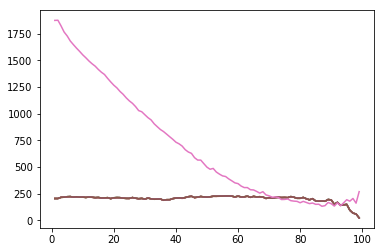

In [7]:
plt.plot(k)
plt.plot(g)

The average time a player is alive is higher as his team placement gets closer to one, which makes sense considering that whoever wins has outlived all other players in their match which gives him team placement of one. However, looking at the count and mean graph shows some irregularity towards the right hand side of the graph. The number of teams that place close to 100 are significantly less than teams that place higher. And also the average survival time of teams close to 100 are higher than what would be expected considering the trend of the rest of the means. This irregularity in the count can be understood if party size column is observed. Since we are looking at games that are not exclusively solo players, party size equal to one, this means that the number of teams in a match can be much less than 100 since only 100 players can be in any given match and party size in a match can differ.

In [8]:
mu = np.mean(i)
sigma = np.std(i)
fit = norm.pdf(i,np.mean(i),np.std(i))

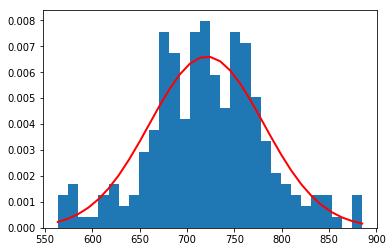

In [10]:
count, bins, ignored = plt.hist(i,bins=30,normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()